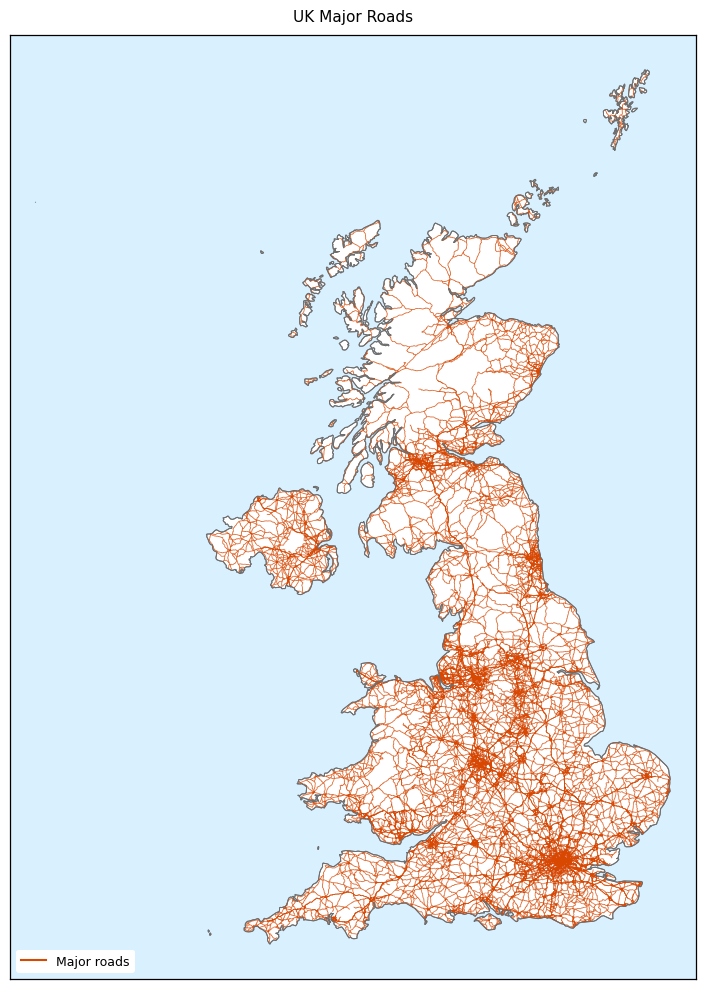

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

PATH_ROADS = r"/Users/hester/Desktop/data/uk_major_roads_epsg3035.gpkg"
PATH_WORLD = r"/Users/hester/Desktop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"

roads = gpd.read_file(PATH_ROADS)
world = gpd.read_file(PATH_WORLD)

uk = world[
    (world.get("ADM0_A3", "") == "GBR") |
    (world.get("NAME", "") == "United Kingdom") |
    (world.get("ADMIN", "") == "United Kingdom")].copy()

if uk.empty:
    raise ValueError("没有在 ne_10m_admin_0_countries 里找到英国。请打印 world.columns 和 world[['NAME','ADMIN','ADM0_A3']].head() 看字段。")

uk = uk.dissolve() 
uk = uk.set_geometry(uk.geometry.buffer(0)) 


uk = uk.to_crs(roads.crs)

roads_uk = gpd.clip(roads, uk)

fig, ax = plt.subplots(1, 1, figsize=(8, 10))

ax.set_facecolor("#d9f0ff")

uk.plot(ax=ax, facecolor="white", edgecolor="#6e6e6e", linewidth=0.7, zorder=1)


roads_uk.plot(ax=ax, color="#d94801", linewidth=0.55, alpha=0.9, zorder=2)

uk.boundary.plot(ax=ax, color="#6e6e6e", linewidth=0.7, zorder=3)

ax.set_title("UK Major Roads", fontsize=11, pad=10)
from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0], [0],
        color="#d94801",      
        linewidth=1.5,
        label="Major roads")]

ax.legend(
    handles=legend_elements,
    loc="lower left",       
    frameon=True,
    framealpha=1,
    facecolor="white",
    edgecolor="none",
    fontsize=9)


minx, miny, maxx, maxy = uk.total_bounds
pad_x = (maxx - minx) * 0.04
pad_y = (maxy - miny) * 0.04
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()
fig.savefig("UK Major Roads.png", dpi=300, bbox_inches="tight")

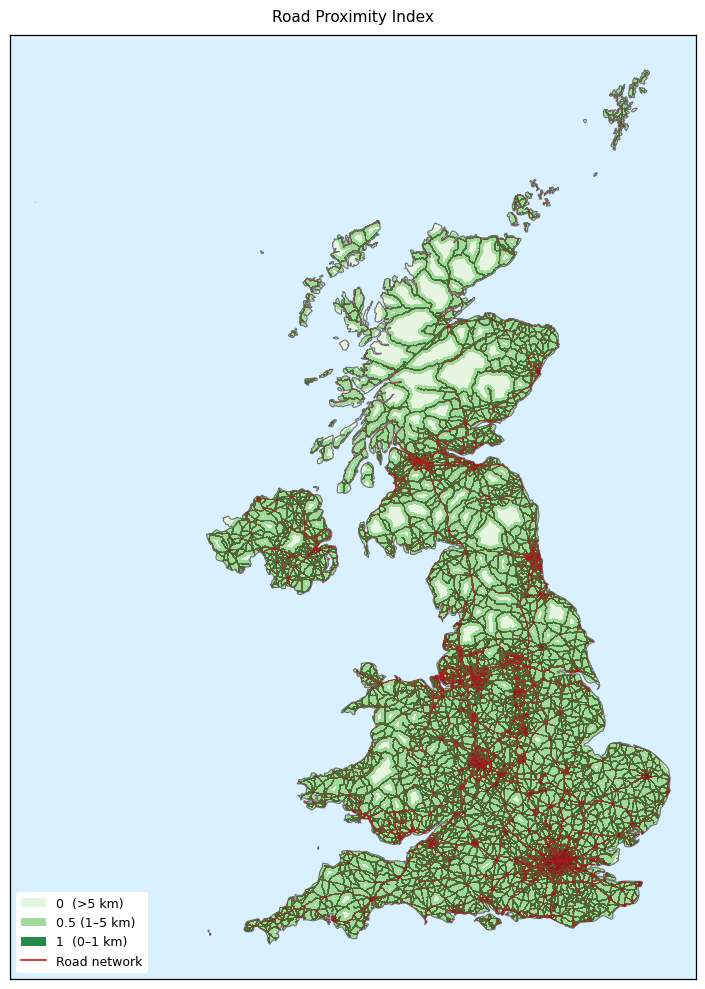

Saved raster: road_proximity_index_200m.tif


In [10]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.mask import mask
import rasterio.plot

from scipy.ndimage import distance_transform_edt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

PATH_ROADS = r"/Users/hester/Desktop/data/uk_major_roads_epsg3035.gpkg"
PATH_WORLD = r"/Users/hester/Desktop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
OUT_TIF  = r"road_proximity_index_200m.tif"            

roads = gpd.read_file(PATH_ROADS)

world = gpd.read_file(PATH_WORLD)
uk = world[
    (world.get("ADM0_A3", "") == "GBR") |
    (world.get("NAME", "") == "United Kingdom") |
    (world.get("ADMIN", "") == "United Kingdom")
].copy()

if uk.empty:
    raise ValueError("没有在 ne_10m_admin_0_countries 里找到 UK。请检查字段 NAME/ADMIN/ADM0_A3。")

uk = uk.dissolve()
uk["geometry"] = uk.geometry.buffer(0) 

uk = uk.to_crs(roads.crs)

roads_uk = gpd.clip(roads, uk)

RES = 200 

minx, miny, maxx, maxy = uk.total_bounds
pad = 2000  
minx -= pad; miny -= pad; maxx += pad; maxy += pad

width  = int(np.ceil((maxx - minx) / RES))
height = int(np.ceil((maxy - miny) / RES))

transform = from_origin(minx, maxy, RES, RES)

shapes = [(geom, 1) for geom in roads_uk.geometry if geom is not None]
road_r = rasterize(
    shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=True
)

non_road = (road_r == 0)
dist_pix = distance_transform_edt(non_road)     
dist_m   = dist_pix * RES                        

idx = np.zeros_like(dist_m, dtype="float32")
idx[dist_m <= 1000] = 1.0
idx[(dist_m > 1000) & (dist_m <= 5000)] = 0.5
idx[dist_m > 5000] = 0.0

with rasterio.open(
    OUT_TIF, "w",
    driver="GTiff",
    height=height, width=width,
    count=1, dtype="float32",
    crs=roads.crs,
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(idx, 1)

with rasterio.open(OUT_TIF) as src:
    idx_clip, clip_transform = mask(src, uk.geometry, crop=True, filled=True, nodata=np.nan)
    idx_clip = idx_clip[0] 


cmap = ListedColormap([
    "#e5f5e0",
    "#a1d99b",  
    "#238b45"  
])

norm = BoundaryNorm([-0.1, 0.25, 0.75, 1.1], cmap.N)


fig, ax = plt.subplots(1, 1, figsize=(8,10))

ax.set_facecolor("#d9f0ff")

rasterio.plot.show(idx_clip, transform=clip_transform, ax=ax, cmap=cmap, norm=norm, interpolation="nearest", zorder=1)

uk.boundary.plot(ax=ax, edgecolor="#6e6e6e", linewidth=0.8, zorder=3)

roads_uk.plot(ax=ax, color="#cb181d", linewidth=0.35, alpha=0.85, zorder=4)

ax.set_title("Road Proximity Index", fontsize=11, pad=10)

# legend
legend_elements = [
    Patch(facecolor="#e5f5e0", edgecolor="none", label="0  (>5 km)"),
    Patch(facecolor="#a1d99b", edgecolor="none", label="0.5 (1–5 km)"),
    Patch(facecolor="#238b45", edgecolor="none", label="1  (0–1 km)"),
    Line2D([0], [0], color="#cb181d", linewidth=1.2, label="Road network")
]
ax.legend(handles=legend_elements, loc="lower left",
          frameon=True, framealpha=1, facecolor="white", edgecolor="none", fontsize=9)
minx, miny, maxx, maxy = uk.total_bounds
pad_x = (maxx - minx) * 0.04
pad_y = (maxy - miny) * 0.04
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()

print(f"Saved raster: {OUT_TIF}")
fig.savefig("Road Proximity Index.png", dpi=300, bbox_inches="tight")